## Preparation

### Library

In [54]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', '{:,.2f}'.format)

### Helper

In [55]:
def cek_null(df_data):
  nan_counts = df_data.isnull().sum()
  nan_proportions = (nan_counts / len(df_data)) * 100

  nan_info = pd.DataFrame({
      'NaN_Count': nan_counts,
      'NaN_Proportion': nan_proportions
  })

  return nan_info.sort_values(by='NaN_Count', ascending=False)

def count_unique_values(df_data):
  unique_counts = []
  for col in df_data.columns:
    unique_counts.append({'Column_Name': col, 'Unique_Value_Count': df_data[col].nunique()})
  return pd.DataFrame(unique_counts)

def heatmap_null(df,att_name):
  plt.figure(figsize=(10, 6))
  sns.heatmap(df[[att_name]].isnull(), cbar=False, cmap='viridis')
  plt.title(f'Heatmap of Null Values in {att_name}')
  plt.show()

def null_proportion(df, att_name):
    # Hitung proporsi null dan non-null berdasarkan loan_status
    null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.isnull().sum() / len(x) * 100)
    non_null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.notnull().sum() / len(x) * 100)

    # Gabungkan data untuk plotting
    plot_data = pd.DataFrame({
        'Null Proportion': null_by_loan_status,
        'Non-Null Proportion': non_null_by_loan_status
    })

    plot_data = plot_data.stack().reset_index()
    plot_data.columns = ['Loan Status', 'Type', 'Proportion']

    # Buat plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Loan Status', y='Proportion', hue='Type', data=plot_data)

    # Tambahkan label persentase di atas setiap batang
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title(f'Proportion of Null and Non-Null Values in {att_name} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel('Proportion (%)')
    plt.ylim(0, 100)
    plt.legend(title='Value Type')
    plt.tight_layout()
    plt.show()

def hist_att(df,att_name):
  plt.figure(figsize=(12, 6))
  df[att_name].value_counts().sort_index().plot(kind='line')
  plt.title(f'Line Plot of {att_name} Distribution')
  plt.xlabel(att_name)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

def metrik(y_true, y_pred, y_prob):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_prob)
  return acc, prec, rec, f1, roc


### Parameter

In [56]:
threshold = 0.9

skor = 90

param_lgbm = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'importance_type': 'gain', # Sesuai kebutuhan seleksi fitur Anda
    'n_jobs': -1,             # Gunakan seluruh core CPU
    'random_state': 42,
    'verbosity': -1           # Menghilangkan pesan log yang tidak perlu
}

param_xgb = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'tree_method': 'hist',        # Wajib untuk data besar (>1 juta baris)
    'importance_type': 'gain',    # Konsistensi dengan metode seleksi fitur Anda
    'n_jobs': -1,
    'random_state': 42
}

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'average_precision', 'roc_auc']

### Load Dataset

In [57]:
df = pd.read_csv("data/loan.csv", low_memory=True)
df.shape

(2260668, 145)

## Pre Procession

### Feature Reduction

#### Loan Status Distribution

In [97]:
# Hitung distribusi
status_counts = df['loan_status'].value_counts()

# Setup style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))

# Buat bar plot horizontal
ax = sns.barplot(
    x=status_counts.values, 
    y=status_counts.index, 
    palette="viridis"
)

# Tambahkan label nilai dan persentase
total = len(df)
for i, (count, label) in enumerate(zip(status_counts.values, status_counts.index)):
    percentage = (count / total) * 100
    ax.text(
        count + total * 0.01, 
        i, 
        f'{count:,} ({percentage:.1f}%)', 
        va='center', 
        fontsize=10, 
        fontweight='bold'
    )

# Judul dan label
plt.title('Loan Status Distribution (loan_status)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Loan Amount', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

ValueError: Image size of 256667966x414 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 800x400 with 1 Axes>

#### Filtering Loan Status

In [98]:
statuses = [
    'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid',
    'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'
]
df = df.loc[df['loan_status'].isin(statuses)].copy()

#### Zero Variance Columns

In [99]:
%%time
unique_value_df = count_unique_values(df)
columns_to_drop = unique_value_df.loc[unique_value_df['Unique_Value_Count'] <= 1]['Column_Name'].tolist()
df = df.drop(columns=columns_to_drop)

CPU times: total: 15.6 ms
Wall time: 0 ns


#### Feature Engineering

In [100]:
%%time
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
years_diff = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['issue_d_date'].dt.year)
months_diff = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['issue_d_date'].dt.month)
df['credit_duration'] = years_diff * 12 + months_diff
df['credit_duration'] = df['credit_duration'].astype(int)

df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
years_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['earliest_cr_line_date'].dt.year.fillna(0))
months_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['earliest_cr_line_date'].dt.month.fillna(0))
df['earliest_credit_duration'] = years_diff_earliest * 12 + months_diff_earliest
df['earliest_credit_duration'] = df['earliest_credit_duration'].astype(int)

att_drop = ['issue_d','issue_d_date','earliest_cr_line','earliest_cr_line_date']
df = df.drop(columns=att_drop)

CPU times: total: 0 ns
Wall time: 0 ns


KeyError: 'issue_d'

#### Eliminate features with dominant missing values (> 50%).

In [ ]:
%%time
nan_info = cek_null(df)
columns_to_drop_nan = nan_info[nan_info['NaN_Proportion'] > 50].index.tolist()
df = df.drop(columns=columns_to_drop_nan)

CPU times: total: 297 ms
Wall time: 299 ms


#### Eliminate high‑cardinality categorical features & textual information.

In [ ]:
%%time
att_drop = ['emp_title', 'title', 'zip_code', 'addr_state']
df = df.drop(columns=att_drop, errors='ignore')

CPU times: total: 0 ns
Wall time: 0 ns


#### Eliminate Data Leakage

In [ ]:
att_leakage = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'hardship_flag', 'debt_settlement_flag', 'last_credit_pull_d']
df = df.drop(columns=att_leakage)

### Encoding

In [ ]:
%%time
non_numeric_cols = df.select_dtypes(exclude=np.number).columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(f"- {col}")

Non-numeric columns:
- term
- grade
- sub_grade
- emp_length
- home_ownership
- verification_status
- loan_status
- purpose
- initial_list_status
- application_type
- disbursement_method
CPU times: total: 0 ns
Wall time: 4.77 ms


In [ ]:
%%time
# Identify non‑numeric columns besides the target
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'loan_status' in non_numeric_cols:
    non_numeric_cols.remove('loan_status')

# Label Encoding
le = LabelEncoder()
for col in non_numeric_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    df[col] = pd.to_numeric(df[col])

CPU times: total: 1.55 s
Wall time: 1.56 s


In [ ]:
%%time
map = {
    'Fully Paid':0, 'Does not meet the credit policy. Status:Fully Paid':0,
    'Charged Off':1, 'Default':1, 'Does not meet the credit policy. Status:Charged Off':1
}
df['loan_status'] = df['loan_status'].map(map)
df['loan_status'] = pd.to_numeric(df['loan_status'])

CPU times: total: 78.1 ms
Wall time: 73.8 ms


### Loan Status Distribution

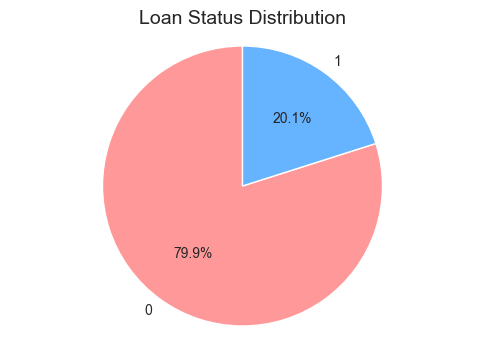

In [ ]:
counts = df['loan_status'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.pie(counts, 
        labels=counts.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'])

plt.title('Loan Status Distribution', fontsize=14)
plt.axis('equal')
plt.show()

### Correlation vs Feature Importance Gain

#### Multicollinearity analysis: Identify features with high correlation.

In [ ]:
%%time
# 1. Calculate correlation matrix without 'loan_status'
corr_matrix = df.drop(columns=['loan_status'], errors='ignore').corr(numeric_only=True)

# 2. Take the upper triangle of the matrix to avoid duplicates and diagonal.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Convert to a long‑format DataFrame (unpivot/stack).
high_corr_df = upper_tri.stack().reset_index()
high_corr_df.columns = ['Attribute_1', 'Attribute_2', 'Correlation']

# 4. Filter correlation values >= threshold and sort from highest to lowest.
high_corr_df = high_corr_df[high_corr_df['Correlation'] >= threshold].sort_values(by='Correlation', ascending=False)

# Menampilkan hasil
high_corr_df

CPU times: total: 6.78 s
Wall time: 6.84 s


,Attribute_1,Attribute_2,Correlation
1,loan_amnt,funded_amnt,1.00
68,funded_amnt,funded_amnt_inv,1.00
1106,open_acc,num_sats,1.00
2,loan_amnt,funded_amnt_inv,1.00
2887,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.98
403,grade,sub_grade,0.98
271,int_rate,sub_grade,0.98
1775,tot_cur_bal,tot_hi_cred_lim,0.97
71,funded_amnt,installment,0.95
5,loan_amnt,installment,0.95


#### Iterative Feature Selection: Integration of Correlation and Gain Importance.

In [ ]:
%%time

def iterative_feature_selection_optimized(X, y, threshold, sample_size=0.5):
    # 1. Sampling handling (supports 0 < sample_size <= 1).
    if sample_size < 1.0:
        print(f"Sampling {sample_size*100}% data for feature selection...")
        X_s, _, y_s, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
    else:
        print("Utilize all data (100%) for feature selection....")
        X_s, y_s = X.copy(), y.copy()
    
    # 2. Calculate Gain only once at the start.
    print("Calculate Initial Feature Importance (Gain)...")
    param = param_lgbm | {'is_unbalance': True}
    full_model = LGBMClassifier(**param)
    full_model.fit(X_s, y_s)
    initial_gains = pd.Series(full_model.feature_importances_, index=X_s.columns)
    
    # 3. Calculate Correlation
    corr_matrix = X_s.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for idx in upper.index:
            if upper.loc[idx, col] > threshold:
                high_corr_pairs.append((idx, col))
    
    dropped_features = set()
    print(f"Analyzing {len(high_corr_pairs)} high correlation pairs....\n")

    # 4. Seleksi Berdasarkan Gain
    for feat_a, feat_b in high_corr_pairs:
        if feat_a in dropped_features or feat_b in dropped_features:
            continue
            
        gain_a = initial_gains.get(feat_a, 0)
        gain_b = initial_gains.get(feat_b, 0)
        
        # Drop items with lower gain.
        final_drop = feat_a if gain_a < gain_b else feat_b
        dropped_features.add(final_drop)
        
        print(f"Pair: ({feat_a}, {feat_b}) | Gain: {feat_a}={gain_a:.2f}, {feat_b}={gain_b:.2f}")
        print(f" > Decision: Drop {final_drop}\n")

    final_list = list(dropped_features)
    return X.drop(columns=final_list), final_list

# Execution
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_final, dropped_list = iterative_feature_selection_optimized(X, y, threshold=0.9, sample_size=0.5)

Sampling 50.0% data for feature selection...
Calculate Initial Feature Importance (Gain)...
Analyzing 13 high correlation pairs....

Pair: (loan_amnt, funded_amnt) | Gain: loan_amnt=18217.92, funded_amnt=7499.24
 > Decision: Drop funded_amnt

Pair: (loan_amnt, funded_amnt_inv) | Gain: loan_amnt=18217.92, funded_amnt_inv=3114.96
 > Decision: Drop funded_amnt_inv

Pair: (loan_amnt, installment) | Gain: loan_amnt=18217.92, installment=36803.56
 > Decision: Drop loan_amnt

Pair: (int_rate, grade) | Gain: int_rate=35212.32, grade=2246831.68
 > Decision: Drop int_rate

Pair: (grade, sub_grade) | Gain: grade=2246831.68, sub_grade=2630191.32
 > Decision: Drop grade

Pair: (num_actv_rev_tl, num_rev_tl_bal_gt_0) | Gain: num_actv_rev_tl=45550.39, num_rev_tl_bal_gt_0=1181.64
 > Decision: Drop num_rev_tl_bal_gt_0

Pair: (open_acc, num_sats) | Gain: open_acc=0.00, num_sats=0.00
 > Decision: Drop num_sats

Pair: (tot_cur_bal, tot_hi_cred_lim) | Gain: tot_cur_bal=3344.81, tot_hi_cred_lim=25422.07
 > D

In [ ]:
dropped_list

['funded_amnt_inv',
 'grade',
 'num_rev_tl_bal_gt_0',
 'loan_amnt',
 'earliest_credit_duration',
 'int_rate',
 'funded_amnt',
 'num_sats',
 'tot_cur_bal']

In [ ]:
df = df.drop(columns=dropped_list)

### Drop Null Value

In [ ]:
cek_null(df).loc[cek_null(df)['NaN_Proportion'] > 0]

,NaN_Count,NaN_Proportion
mths_since_recent_inq,172301,13.19
num_tl_120dpd_2m,118320,9.06
mo_sin_old_il_acct,107044,8.19
pct_tl_nvr_dlq,70430,5.39
avg_cur_bal,70297,5.38
mo_sin_rcnt_rev_tl_op,70277,5.38
num_rev_accts,70277,5.38
mo_sin_old_rev_tl_op,70277,5.38
total_rev_hi_lim,70276,5.38
tot_coll_amt,70276,5.38


In [ ]:
df_null = cek_null(df)
att_null = df_null.loc[df_null['NaN_Proportion'] > 0].index.to_list()
df = df.dropna(subset=att_null)

In [ ]:
df['loan_status'].value_counts()

loan_status
0    817670
1    211349
Name: count, dtype: int64

In [ ]:
df.shape

(1029019, 58)

## Split

In [101]:
%%time

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

CPU times: total: 0 ns
Wall time: 0 ns


KeyError: "['loan_status'] not found in axis"

## RFECV

In [102]:
%%time
# 0. Tentukan fraksi data (0.1 = 10%, 1.0 = 100%)
sample_frac = 0.5

# 1. Logika Pemilihan Data
if sample_frac < 1.0:
    X_proc = X_train_scaled.sample(frac=sample_frac, random_state=42)
    y_proc = y_train.loc[X_proc.index]
else:
    X_proc = X_train_scaled
    y_proc = y_train

# 2. Inisialisasi Model & CV
param = param_lgbm | {"is_unbalance": True}
model = LGBMClassifier(**param)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Konfigurasi RFECV
selector = RFECV(
    estimator=model,
    step=1, 
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Jalankan Seleksi pada data yang dipilih
selector.fit(X_proc, y_proc)

# 5. Hasil Fitur Terbaik
selected_features = X_train.columns[selector.support_].tolist()
print(f"Menggunakan {sample_frac*100}% data")
print(f"Jumlah fitur optimal: {selector.n_features_}")
print(f"Fitur terpilih: {selected_features}")

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

In [103]:
# 1. Ambil skor pentingnya fitur dari model internal RFECV
importances = selector.estimator_.feature_importances_

# 2. Pasangkan dengan nama fitur yang terpilih
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Score': importances
}).sort_values(by='Importance_Score', ascending=False)

feature_scores.head(10)

,Feature,Importance_Score
2,sub_grade,"3,131,598.29"
20,credit_duration,"240,695.45"
0,term,"186,281.76"
11,avg_cur_bal,"113,454.96"
7,dti,"80,963.07"
1,installment,"46,351.54"
4,home_ownership,"44,877.25"
3,emp_length,"43,002.79"
14,mort_acc,"41,513.57"
10,acc_open_past_24mths,"33,244.00"


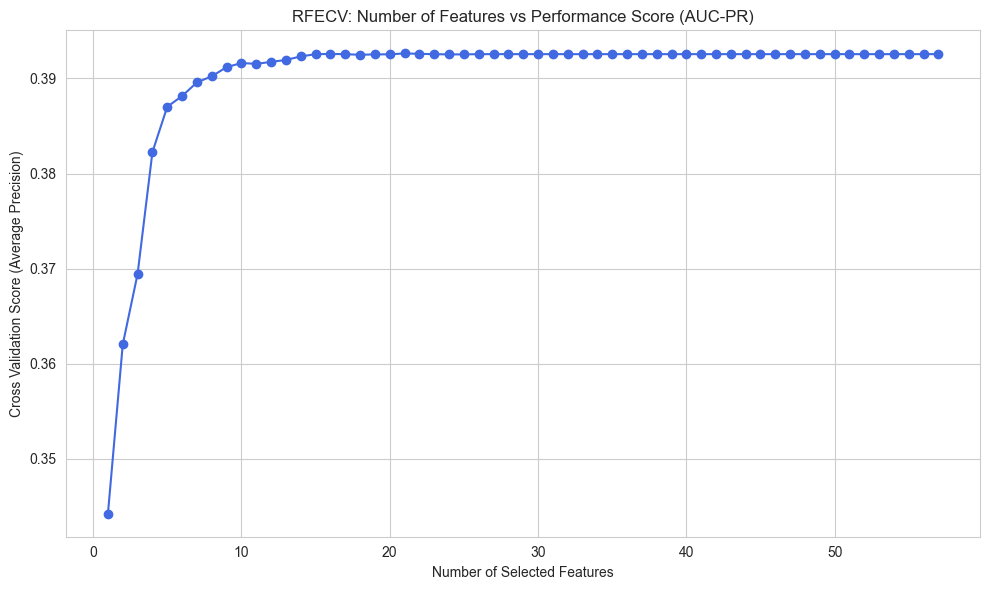

In [104]:
# Plotting hasil RFECV
plt.figure(figsize=(10, 6))
plt.title('RFECV: Number of Features vs Performance Score (AUC-PR)')
plt.xlabel('Number of Selected Features')
plt.ylabel('Cross Validation Score (Average Precision)')

# Mengambil skor dari selector
# Range x dimulai dari 1 hingga jumlah total fitur awal
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'], 
         marker='o', color='royalblue')

plt.grid(True)
plt.tight_layout()
plt.savefig('rfecv_performance_plot.png')

Jumlah Fitur Optimal (Titik Siku): 9


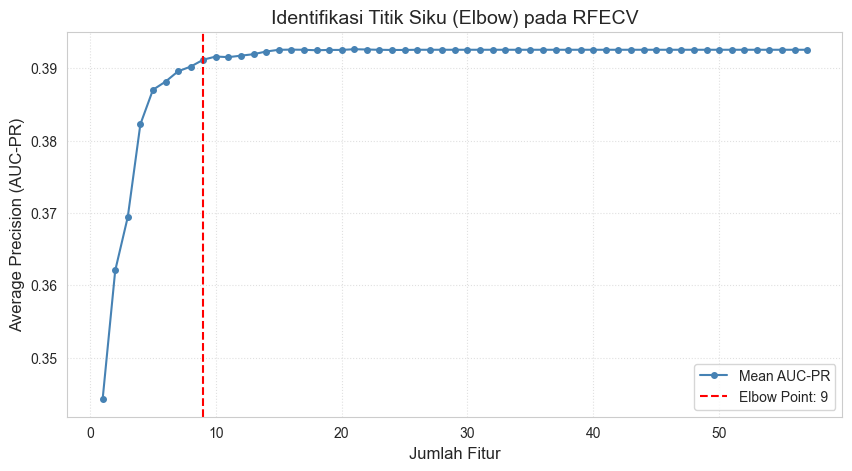

In [105]:
from kneed import KneeLocator
# import matplotlib.pyplot as plt

# 1. Ekstrak skor rata-rata dari hasil RFECV
# cv_results_['mean_test_score'] menyimpan performa tiap jumlah fitur
scores = selector.cv_results_['mean_test_score']
num_features = range(1, len(scores) + 1)

# 2. Gunakan KneeLocator untuk mencari titik di mana grafik mulai melandai
# Curve 'concave' dan direction 'increasing' cocok untuk kurva akurasi/AUC-PR
kn = KneeLocator(num_features, scores, curve='concave', direction='increasing')
elbow_point = kn.knee

print(f"Jumlah Fitur Optimal (Titik Siku): {elbow_point}")

# 3. Visualisasi untuk validasi
plt.figure(figsize=(10, 5))
plt.plot(num_features, scores, color='steelblue', marker='o', markersize=4, label='Mean AUC-PR')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point: {elbow_point}')

plt.title('Identifikasi Titik Siku (Elbow) pada RFECV', fontsize=14)
plt.xlabel('Jumlah Fitur', fontsize=12)
plt.ylabel('Average Precision (AUC-PR)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [106]:
selected_features[:9]

['term',
 'installment',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'dti',
 'revol_bal']

In [107]:
att = selected_features[:9]
# att = feature_scores['Feature'].to_list()[:9]

Varians PC1: 0.2057 (20.57%)
Varians PC2: 0.1736 (17.36%)
Total Informasi yang Terjaga: 0.3792 (37.92%)


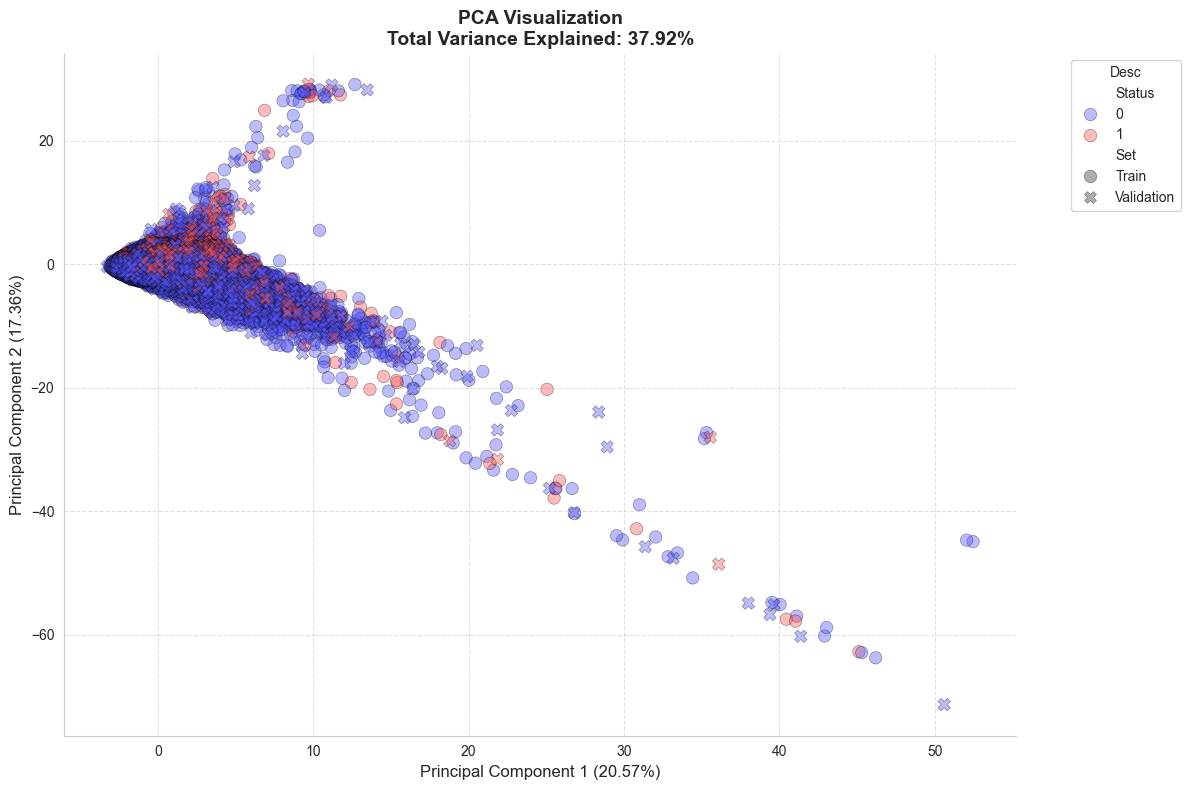

CPU times: total: 13.8 s
Wall time: 14.1 s


In [108]:
%%time
# 1. Inisialisasi PCA untuk 2 Komponen Utama
pca = PCA(n_components=2)

# 2. Fit pada data training dan transformasi
# Kita gunakan .values karena PCA dari sklearn bekerja optimal dengan numpy array
# att = ['sub_grade', 'credit_duration', 'term', 'avg_cur_bal', 'dti', 'installment', 'home_ownership', 'emp_length', 'mort_acc']
# att = ['sub_grade', 'credit_duration', 'term', 'avg_cur_bal', 'dti', 'installment', 'home_ownership', 'emp_length', 'mort_acc', 'acc_open_past_24mths', 'tot_hi_cred_lim', 'num_actv_rev_tl', 'annual_inc', 'total_bc_limit', 'bc_open_to_buy', 'verification_status', 'mo_sin_old_rev_tl_op', 'num_actv_bc_tl', 'revol_bal', 'total_rev_hi_lim', 'num_bc_sats']
X_train_pca = pca.fit_transform(X_train_scaled[att].values)
X_val_pca = pca.transform(X_val_scaled[att].values)

# 3. Cek Explained Variance Ratio (Penting untuk analisis tesis)
varians_pc1 = pca.explained_variance_ratio_[0]
varians_pc2 = pca.explained_variance_ratio_[1]
total_varians = varians_pc1 + varians_pc2

print(f"Varians PC1: {varians_pc1:.4f} ({varians_pc1*100:.2f}%)")
print(f"Varians PC2: {varians_pc2:.4f} ({varians_pc2*100:.2f}%)")
print(f"Total Informasi yang Terjaga: {total_varians:.4f} ({total_varians*100:.2f}%)")

# 4. Membuat DataFrame hasil PCA untuk memudahkan plotting
# Kita gabungkan hasil PCA dengan label asli (y_train dan y_val)
df_pca_train = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_pca_train['Status'] = y_train.values
df_pca_train['Set'] = 'Train'

df_pca_val = pd.DataFrame(X_val_pca, columns=['PC1', 'PC2'])
df_pca_val['Status'] = y_val.values
df_pca_val['Set'] = 'Validation'

# Gabungkan untuk plotting sekaligus (opsional, tapi bagus untuk melihat distribusi gabungan)
df_pca_combined = pd.concat([df_pca_train, df_pca_val], ignore_index=True)

# 5. Visualisasi
plt.figure(figsize=(12, 8))

# Gunakan seaborn scatterplot untuk visualisasi yang lebih cantik
# hue='Status' akan otomatis memberi warna berbeda berdasarkan kelas (Gagal Bayar vs Lunas)
sns.scatterplot(
    data=df_pca_combined,
    x='PC1', 
    y='PC2', 
    hue='Status', 
    style='Set',       # Membedakan Train (lingkaran) dan Val (segitiga/kotak)
    palette='seismic', # Palet warna merah-biru yang umum untuk klasifikasi biner
    alpha=0.4,
    s=80,              # Ukuran titik
    edgecolor='k',     # Garis tepi hitam tipis agar titik terlihat jelas
    linewidth=0.5
)

plt.title(f'PCA Visualization\nTotal Variance Explained: {total_varians*100:.2f}%', fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({varians_pc1*100:.2f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({varians_pc2*100:.2f}%)', fontsize=12)
plt.legend(title='Desc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Hilangkan border atas dan kanan agar lebih bersih (gaya jurnal)
sns.despine()

plt.tight_layout()
plt.show()

## Modelling

### Scenario A

#### LightGBM

In [109]:
%%time
# 1. Filter Fitur Hasil RFECV
# Memastikan model hanya menggunakan fitur paling optimal
X_train_a = X_train_scaled[att]
X_val_a = X_val_scaled[att]

# 2. Inisialisasi Model LightGBM Skenario A
# is_unbalance=True: Model memberikan bobot lebih pada kelas minoritas secara otomatis
param = param_lgbm | {"is_unbalance":True}
model_lgbm_a = LGBMClassifier(**param)

# 3. Pelaksanaan Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scoring_metrics = ['f1', 'average_precision', 'roc_auc']

print("Menjalankan Cross-Validation (5-Fold)...")
cv_results = cross_validate(
    model_lgbm_a, 
    X_train_a, 
    y_train, 
    cv=skf, 
    scoring=scoring_metrics, 
    n_jobs=-1
)

# 4. Pelatihan pada Seluruh Data Training
model_lgbm_a.fit(X_train_a, y_train)

# 5. Pengujian pada Data Validasi
y_pred = model_lgbm_a.predict(X_val_a)
y_proba = model_lgbm_a.predict_proba(X_val_a)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A")
print("="*30)

# Rata-rata Skor Cross Validation
print(f"CV F1-Score         : {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results['test_roc_auc'].mean():.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred))

auc_pr = average_precision_score(y_val, y_proba)
print(f"Final AUC-PR on Validation: {auc_pr:.4f}")

Menjalankan Cross-Validation (5-Fold)...

HASIL EVALUASI SKENARIO A
CV F1-Score         : 0.3449 (+/- 0.0017)
CV AUC-PR (Avg Prec): 0.3772
CV ROC-AUC          : 0.7083

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87    163534
           1       0.43      0.28      0.34     42270

    accuracy                           0.78    205804
   macro avg       0.63      0.59      0.60    205804
weighted avg       0.75      0.78      0.76    205804

Final AUC-PR on Validation: 0.3763
CPU times: total: 53.8 s
Wall time: 13.1 s


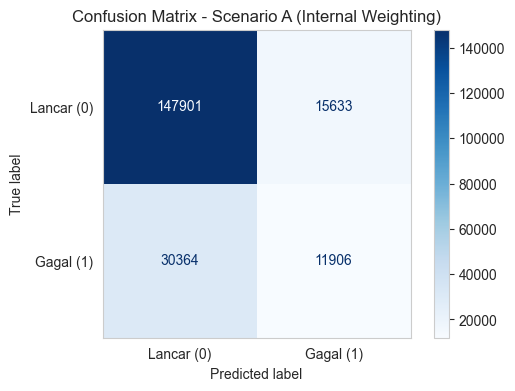

TP: 11906 FN: 30364 FP: 15633 TN: 147901


In [110]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)','Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Scenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

#### XGBoost

In [111]:
%%time
# 1. Filter Fitur Hasil RFECV
X_train_xgb = X_train_scaled[att]
X_val_xgb = X_val_scaled[att]

# 2. Hitung Rasio untuk Penanganan Imbalance
# Formula: sum(negative) / sum(positive)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# 3. Inisialisasi Model XGBoost
param = param_xgb | {"scale_pos_weight":ratio}
model_xgb_a = XGBClassifier(**param)

# 4. Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scoring_metrics = ['f1', 'average_precision', 'roc_auc']

print("Menjalankan Cross-Validation XGBoost (5-Fold)...")
cv_results_xgb = cross_validate(
    model_xgb_a, 
    X_train_xgb, 
    y_train, 
    cv=skf, 
    scoring=scoring_metrics, 
    n_jobs=-1
)

# 5. Training dan Prediksi
model_xgb_a.fit(X_train_xgb, y_train)
y_pred_xgb = model_xgb_a.predict(X_val_xgb)
y_proba_xgb = model_xgb_a.predict_proba(X_val_xgb)[:, 1]

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A: XGBOOST")
print("="*30)

print(f"CV F1-Score         : {cv_results_xgb['test_f1'].mean():.4f} (+/- {cv_results_xgb['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_xgb['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results_xgb['test_roc_auc'].mean():.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_xgb))

auc_pr_xgb = average_precision_score(y_val, y_proba_xgb)
print(f"Final AUC-PR on Validation: {auc_pr_xgb:.4f}")

Menjalankan Cross-Validation XGBoost (5-Fold)...

HASIL EVALUASI SKENARIO A: XGBOOST
CV F1-Score         : 0.4324 (+/- 0.0004)
CV AUC-PR (Avg Prec): 0.3780
CV ROC-AUC          : 0.7085

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.88      0.62      0.73    163534
           1       0.31      0.68      0.43     42270

    accuracy                           0.63    205804
   macro avg       0.60      0.65      0.58    205804
weighted avg       0.76      0.63      0.67    205804

Final AUC-PR on Validation: 0.3769
CPU times: total: 55.5 s
Wall time: 13.9 s


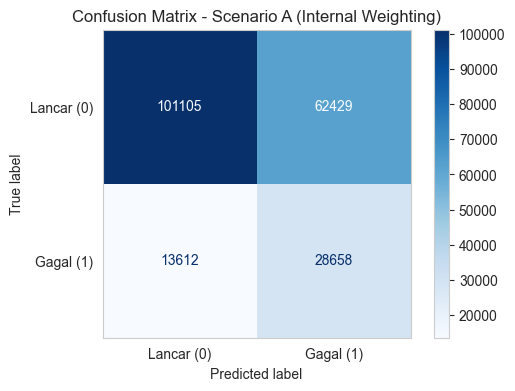

TP: 28658 FN: 13612 FP: 62429 TN: 101105


In [112]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_xgb)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Scenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

### Scenario B

#### LightGBM

In [113]:
%%time
# 1. Data Preparation (Only using selected features from RFECV)
X_train_b = X_train_scaled[att]
X_val_b = X_val_scaled[att]

# 2. ADASYN Configuration (CPU Optimization)
nn_params = NearestNeighbors(n_neighbors=5, n_jobs=-1)
adasyn = ADASYN(random_state=42, n_neighbors=nn_params, sampling_strategy='auto')

param = param_lgbm | {"is_unbalance":False}

# 3. LightGBM Modeling (is_unbalance disabled)
model_lgbm_b = LGBMClassifier(**param)

# 4.Cross-Validation with Pipeline (Avoiding Data Leakage)
pipeline_lgbm = ImbPipeline([
    ('resample', adasyn),
    ('classifier', model_lgbm_b)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Running Cross-Validation Scenario B (LGBM + ADASYN)...")
cv_results_b = cross_validate(
    pipeline_lgbm, 
    X_train_b, y_train, 
    cv=skf, 
    scoring=scoring_metrics,
    n_jobs=-1 
)

# 5. Final Resampling & Training for Validation Prediction
print("Perform Final Resampling on the entire Train data...")
X_train_res, y_train_res = adasyn.fit_resample(X_train_b, y_train)

print("Final Model Training Scenario B...")
model_lgbm_b.fit(X_train_res, y_train_res)

# 6. Testing
y_pred_b = model_lgbm_b.predict(X_val_b)
y_proba_b = model_lgbm_b.predict_proba(X_val_b)[:, 1]

# --- Output ---
title = "EVALUATION RESULTS SCENARIO B: LGBM + ADASYN"
print("\n" + "="*len(title))
print(title)
print("="*len(title))
print(f"CV F1-Score         : {cv_results_b['test_f1'].mean():.4f} (+/- {cv_results_b['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_b['test_average_precision'].mean():.4f}")
print("\nClassification Report Details (Validation Data):")
print(classification_report(y_val, y_pred_b))

Running Cross-Validation Scenario B (LGBM + ADASYN)...
Perform Final Resampling on the entire Train data...
Final Model Training Scenario B...

EVALUATION RESULTS SCENARIO B: LGBM + ADASYN
CV F1-Score         : 0.3457 (+/- 0.0073)
CV AUC-PR (Avg Prec): 0.3556

Classification Report Details (Validation Data):
              precision    recall  f1-score   support

           0       0.83      0.88      0.86    163534
           1       0.40      0.31      0.35     42270

    accuracy                           0.76    205804
   macro avg       0.61      0.59      0.60    205804
weighted avg       0.74      0.76      0.75    205804

CPU times: total: 23min 2s
Wall time: 2min 14s


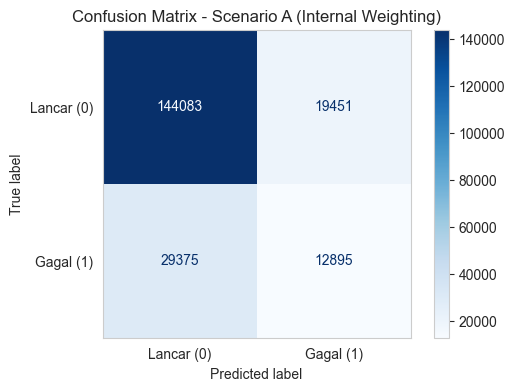

TP: 12895 FN: 29375 FP: 19451 TN: 144083


In [114]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_b)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Scenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

#### XGBoost

In [115]:
%%time
# 1. Inisialisasi Model XGBoost Skenario B
# scale_pos_weight=1: Karena data sudah diseimbangkan secara fisik oleh ADASYN
param = param_xgb | {"scale_pos_weight":1}
model_xgb_b = XGBClassifier(**param)

# 2. Pelatihan Model pada Data ADASYN
print("Training XGBoost on ADASYN‑resampled data...")
model_xgb_b.fit(X_train_res, y_train_res)

# 3. Prediksi pada Data Validasi
y_pred_xgb_b = model_xgb_b.predict(X_val_b)
y_proba_xgb_b = model_xgb_b.predict_proba(X_val_b)[:, 1]

# --- Output Evaluasi ---
title = 'EVALUATION RESULTS SCENARIO B: XGBOOST + ADASYN'
print("\n" + "="*len(title))
print(title)
print("="*len(title))

print("\nClassification Report Details (Validation Data):")
print(classification_report(y_val, y_pred_xgb_b))

auc_pr_xgb_b = average_precision_score(y_val, y_proba_xgb_b)
print(f"Final AUC-PR on Validation: {auc_pr_xgb_b:.4f}")

Training XGBoost on ADASYN‑resampled data...

EVALUATION RESULTS SCENARIO B: XGBOOST + ADASYN

Classification Report Details (Validation Data):
              precision    recall  f1-score   support

           0       0.87      0.64      0.74    163534
           1       0.31      0.63      0.42     42270

    accuracy                           0.64    205804
   macro avg       0.59      0.64      0.58    205804
weighted avg       0.76      0.64      0.67    205804

Final AUC-PR on Validation: 0.3557
CPU times: total: 1min 18s
Wall time: 2.87 s


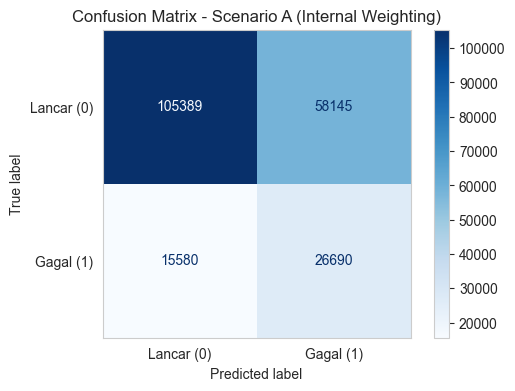

TP: 26690 FN: 15580 FP: 58145 TN: 105389


In [116]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_xgb_b)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Scenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

## Analysis

### PCA

In [117]:
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

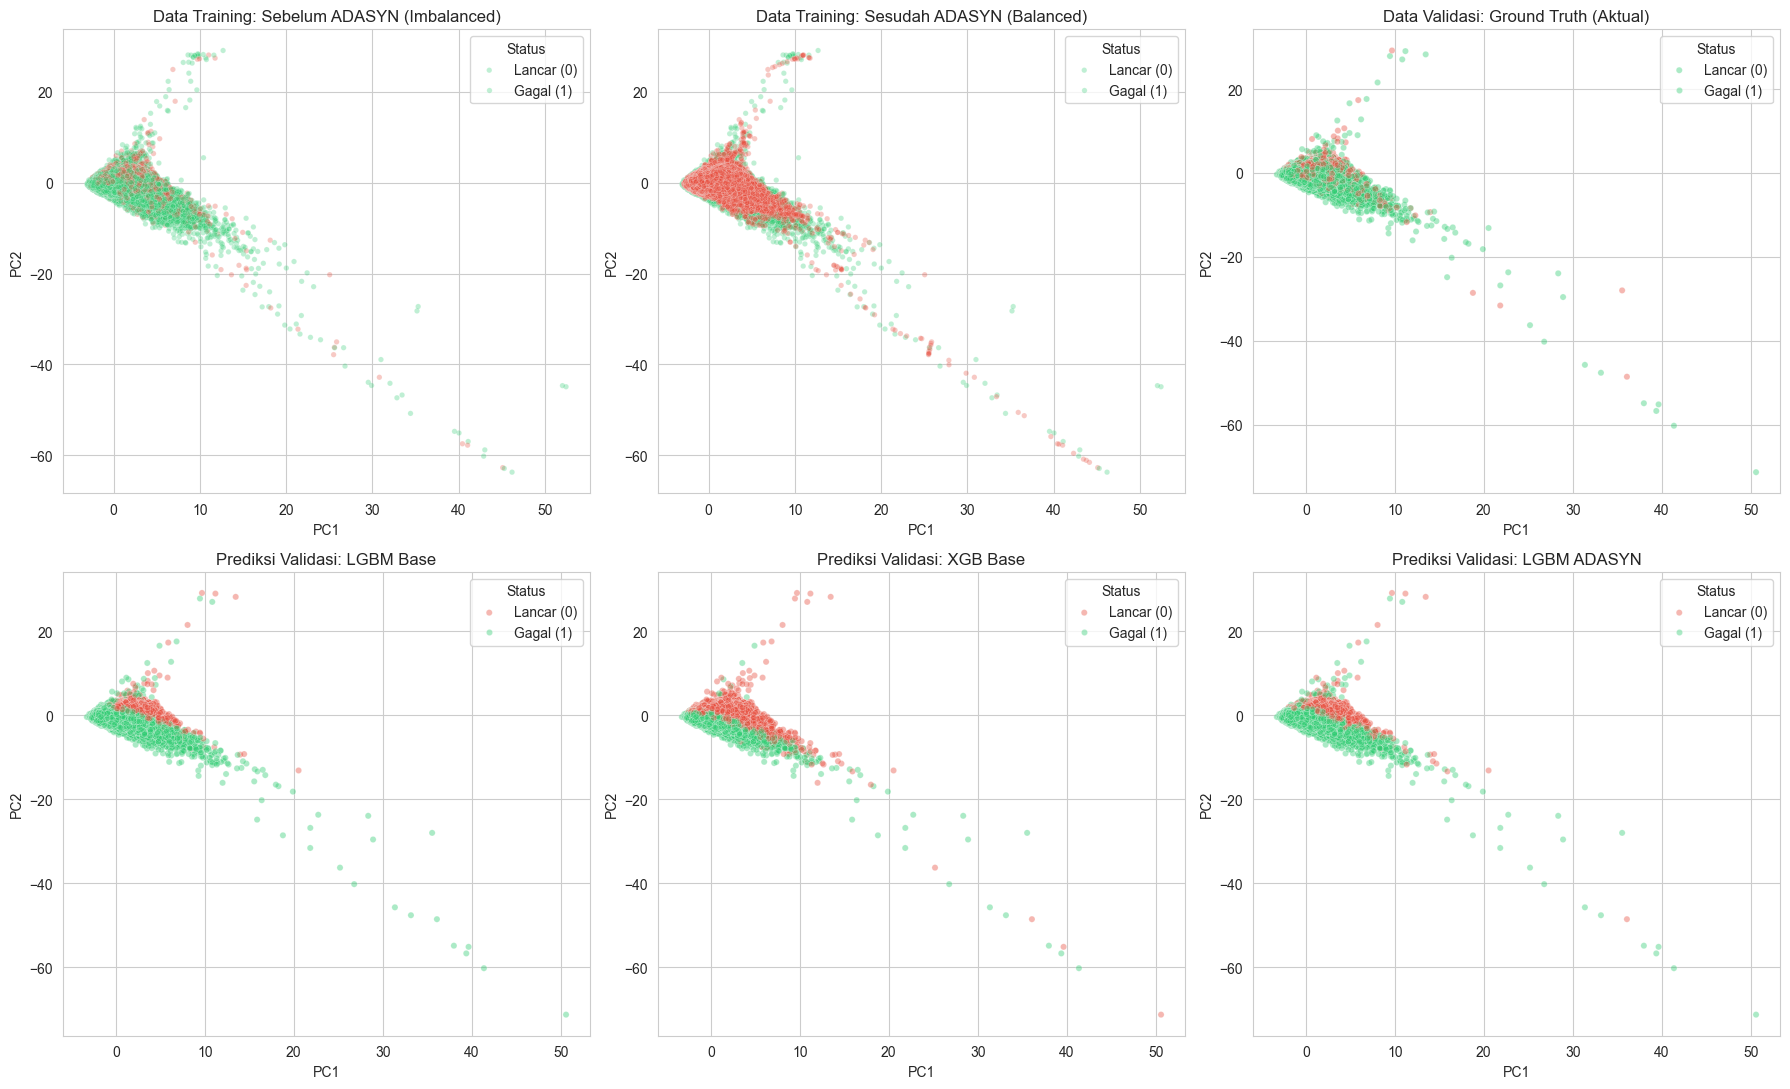

In [118]:
def plot_comprehensive_pca(X_orig, y_orig, X_res, y_res, X_val, y_val, models_dict):
    """
    X_orig, y_orig: Training data before ADASYN
    X_res, y_res  : Training data after ADASYN
    X_val, y_val  : Original validation data
    models_dict   : {'LGBM Base': lgbm_base, 'XGB Base': xgb_base, 
                     'LGBM ADASYN': lgbm_adasyn, 'XGB ADASYN': xgb_adasyn}
    """
    # 1. PCA Initialization (Fit on original data to keep coordinates consistent)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_orig)
    
    # Transform all datasets
    pca_orig = pca.transform(X_orig)
    pca_res = pca.transform(X_res)
    pca_val = pca.transform(X_val)
    
    # 2. Setup Plot Grid (2 Rows: Data Distribution & Model Prediction)
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    palette = {0: '#2ecc71', 1: '#e74c3c'}
    
    # --- ROW 1: TRAINING DATA DISTRIBUTION ---
    # Before ADASYN
    sns.scatterplot(x=pca_orig[:, 0], y=pca_orig[:, 1], hue=y_orig, 
                    ax=axes[0, 0], palette=palette, alpha=0.3, s=15)
    axes[0, 0].set_title("Data Training: Sebelum ADASYN (Imbalanced)", fontsize=12)
    
    # After ADASYN
    sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=y_res, 
                    ax=axes[0, 1], palette=palette, alpha=0.3, s=15)
    axes[0, 1].set_title("Data Training: Sesudah ADASYN (Balanced)", fontsize=12)
    
    # Ground Truth Validasi
    sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_val, 
                    ax=axes[0, 2], palette=palette, alpha=0.4, s=20)
    axes[0, 2].set_title("Data Validasi: Ground Truth (Aktual)", fontsize=12)

    # --- ROW 2: MODEL PREDICTION ON VALIDATION DATA ---
    model_names = list(models_dict.keys())[:3] 
    
    for i, name in enumerate(model_names):
        y_pred = models_dict[name].predict(X_val)
        sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_pred, 
                        ax=axes[1, i], palette=palette, alpha=0.4, s=20)
        axes[1, i].set_title(f"Prediksi Validasi: {name}", fontsize=12)

    for ax in axes.flat:
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend(title="Status", labels=["Lancar (0)", "Gagal (1)"])

    plt.tight_layout()
    plt.show()

models = {'LGBM Base': model_lgbm_a, 'XGB Base': model_xgb_a, 'LGBM ADASYN': model_lgbm_b, 'XGB ADASYN': model_xgb_b}
plot_comprehensive_pca(X_train_scaled[att], y_train, X_resampled[att], y_resampled, X_val_scaled[att], y_val, models)